# Imports

In [315]:
import torch
import pandas 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import copy

In [316]:
training_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("USING DEVICE:", training_device)

USING DEVICE: cuda


# Setting up the Dataset

In [317]:
import pandas as pd
df_noise=pd.read_csv("/kaggle/input/train-test-data/cf_train.csv")
df_no_noise = pd.read_csv("/kaggle/input/train-test-data/cf_train_no_noise.csv")
df_test_no_noise = pd.read_csv("/kaggle/input/train-test-data/cf_test_no_noise.csv")
df_test_noise = pd.read_csv("/kaggle/input/train-test-data/cf_test.csv")

In [318]:
df_noise_copy=pd.read_csv("/kaggle/input/train-test-data/cf_train.csv")
df_no_noise_copy=pd.read_csv("/kaggle/input/train-test-data/cf_train_no_noise.csv")
df_noise=pd.read_csv("/kaggle/input/train-test-data/cf_train.csv")
df_no_noise=pd.read_csv("/kaggle/input/train-test-data/cf_train_no_noise.csv")
df_test_no_noise_copy = pd.read_csv("/kaggle/input/train-test-data/cf_test_no_noise.csv")
df_test_noise_copy = pd.read_csv("/kaggle/input/train-test-data/cf_test.csv")


unique_labels = df_noise["target_10_val"].unique()
unique_labels.sort()
def label_encoding(value):
    return np.where(unique_labels == value)[0][0]

df_no_noise["target_10_val"] = df_no_noise["target_10_val"].apply(label_encoding)
df_noise["target_10_val"] = df_noise["target_10_val"].apply(label_encoding)
df_test_no_noise["target_10_val"] = df_test_no_noise["target_10_val"].apply(label_encoding)
df_test_noise["target_10_val"] = df_test_noise["target_10_val"].apply(label_encoding)



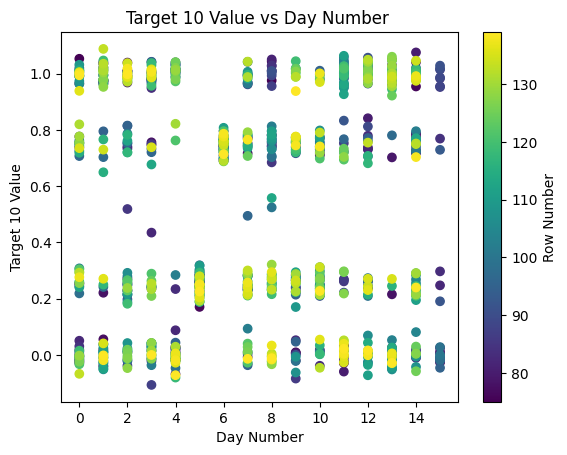

In [319]:
target_10_vals = df_noise_copy.loc[:1000,"target_10_val"].values
day_no = df_noise_copy.loc[:1000,"day_no"].values
row_num = df_noise_copy.loc[:1000,"row_num"].values
for i in range(1000):
    target_10_vals[i] = target_10_vals[i] + np.random.normal(0, 0.03)

plt.scatter(day_no, target_10_vals, c= row_num,alpha = 1, cmap='viridis')
plt.xlabel("Day Number")
plt.ylabel("Target 10 Value")
plt.title("Target 10 Value vs Day Number ")
plt.colorbar().set_label("Row Number")

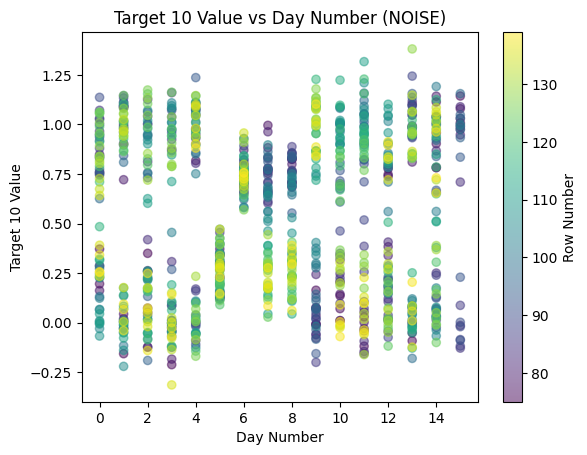

In [379]:
target_10_vals = df_no_noise_copy.loc[:1000,"target_10_val"].values
day_no = df_no_noise_copy.loc[:1000,"day_no"].values
row_num = df_no_noise_copy.loc[:1000,"row_num"].values
for i in range(1000):
    target_10_vals[i] = target_10_vals[i] + np.random.normal(0, 0.09)

plt.scatter(day_no, target_10_vals, c= row_num,alpha = 0.5, cmap='viridis')
plt.xlabel("Day Number")
plt.ylabel("Target 10 Value")
plt.title("Target 10 Value vs Day Number (NOISE)")
plt.colorbar().set_label("Row Number")

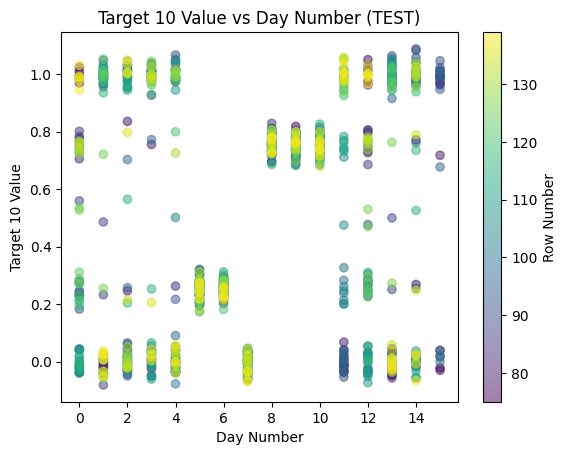

In [321]:
target_10_vals = df_test_no_noise_copy.loc[:1000,"target_10_val"].values
day_no =  df_test_no_noise_copy.loc[:1000,"day_no"].values
row_num =  df_test_no_noise_copy.loc[:1000,"row_num"].values
for i in range(1000):
    target_10_vals[i] = target_10_vals[i] + np.random.normal(0, 0.03)

plt.scatter(day_no, target_10_vals, c= row_num,alpha = 0.5, cmap='viridis')
plt.xlabel("Day Number")
plt.ylabel("Target 10 Value")
plt.title("Target 10 Value vs Day Number (TEST)")
plt.colorbar().set_label("Row Number")

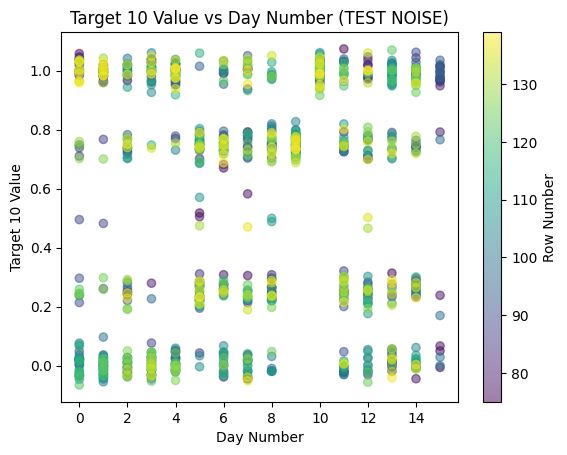

In [322]:
target_10_vals = df_test_noise_copy.loc[:1000,"target_10_val"].values
day_no =  df_test_noise_copy.loc[:1000,"day_no"].values
row_num =  df_test_noise_copy.loc[:1000,"row_num"].values
for i in range(1000):
    target_10_vals[i] = target_10_vals[i] + np.random.normal(0, 0.03)

plt.scatter(day_no, target_10_vals, c= row_num,alpha = 0.5, cmap='viridis')
plt.xlabel("Day Number")
plt.ylabel("Target 10 Value")
plt.title("Target 10 Value vs Day Number (TEST NOISE)")
plt.colorbar().set_label("Row Number")

In [324]:
class CustomDataset_Train:
    def __init__(self,dataframe,batch_size,device =training_device,shuffle=False):
        self.df=dataframe
        self.batch_size=batch_size
        self.columns_to_drop=['row_num','day','era','target_10_val','target_5_val','sigma','day_no']
        self.X = self.df.drop(self.columns_to_drop, axis=1)
        self.y=self.df['target_10_val']
        self.device=device
        self.shuffle=shuffle

    def generate_batches_with_labels(self,idx):
        data=self.X.iloc[:max(0,idx-10)]
        labels=self.y.iloc[:max(0,idx-10)]
        dataset =  torch.utils.data.TensorDataset(torch.tensor(data.values),torch.tensor(labels.values))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=self.shuffle)
        data_online = self.X.iloc[max(0,idx-9):idx+1]
        labels_online =self.y.iloc[max(0,idx-9):idx+1]
        data_online,labels_online = torch.tensor(data_online.values).to(self.device),torch.tensor(labels_online.values).to(self.device)
        online_dataset = torch.utils.data.TensorDataset(data_online,labels_online)
        online_dataloader = torch.utils.data.DataLoader(online_dataset, batch_size=10, shuffle=self.shuffle)
        return dataloader, online_dataloader

In [325]:
class CustomDataset_Test(torch.utils.data.Dataset):
    def __init__(self,dataframe):
        self.df=dataframe
        self.columns_to_drop=['row_num','day','era','target_10_val','target_5_val','sigma','day_no']
        self.X = self.df.drop(self.columns_to_drop, axis=1)
        self.y=self.df['target_10_val']
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return torch.tensor(self.X.iloc[idx].values),torch.tensor(self.y.iloc[idx])
    

# Utils

In [366]:
class CustomLoss(torch.nn.Module):
    def __init__(self, reg, no_of_class):
        super(CustomLoss, self).__init__()
        self.reg = reg
        self.no_of_class = no_of_class

    def forward(self, inputs, targets):
        p = torch.Tensor(inputs[0]).to(training_device).t()

        targets = torch.eye(self.no_of_class).to(training_device)[targets].t()
        tou = torch.Tensor(inputs[1]).to(training_device)
        tou = tou.t()

        loss_a = torch.t(targets) @ torch.log(tou * (p - targets) + targets)
        loss_b = self.reg * torch.log(tou)
        loss_a = loss_a.diag().t()
        
        loss = loss_a + loss_b
        return -loss.mean()

    def custom_p(p):
        return p

# Test Time Adaptation Model (NAL Loss)

In [367]:
class TestTimeModelMLP_NAL(torch.nn.Module):
    def __init__(
        self,
        input_size,
        classification_output_size,
        shared_layers,
        classification_layers,
        auxiliary_layers,
    ):
        super(TestTimeModelMLP_NAL, self).__init__()
        self.input_size = input_size
        shared = []
        for i in range(len(shared_layers)):
            if i == 0:
                shared.append(torch.nn.Linear(input_size, shared_layers[i]))
                shared.append(torch.nn.ReLU())
            elif i < len(shared_layers) - 1:
                shared.append(torch.nn.Linear(shared_layers[i - 1], shared_layers[i]))
                shared.append(torch.nn.ReLU())
            else:
                shared.append(torch.nn.Linear(shared_layers[i - 1], shared_layers[i]))
                shared.append(torch.nn.ReLU())
                shared.append(torch.nn.LayerNorm([shared_layers[i]]))

        self.shared_layers = torch.nn.Sequential(*shared)

        classification = []
        for i in range(len(classification_layers)):
            if i == 0 and len(classification_layers) == 1:
                classification.append(torch.nn.Linear(shared_layers[-1], classification_output_size))
            elif i == 0:
                classification.append(
                    torch.nn.Linear(shared_layers[-1], classification_layers[i])
                )
                classification.append(torch.nn.ReLU())
            elif i < len(classification_layers)-1:
                classification.append(
                    torch.nn.Linear(
                        classification_layers[i - 1], classification_layers[i]
                    )
                )
                classification.append(torch.nn.ReLU())
                classification.append(torch.nn.LayerNorm(classification_layers[i]))
            else:
                classification.append(
                    torch.nn.Linear(
                        classification_layers[i - 1], classification_layers[i]
                    )
                )
                
        
        self.attention_layer = torch.nn.Linear(classification_layers[-1], 1) 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()
        self.classification_head = torch.nn.Linear(classification_layers[-1], classification_output_size)

        self.classification_layers = torch.nn.Sequential(*classification)

        auxiliary = []
        for i in range(len(auxiliary_layers)):
            if i == 0 and len(auxiliary_layers) == 1:
                auxiliary.append(torch.nn.Linear(shared_layers[-1], self.input_size))
            elif i == 0:
                auxiliary.append(
                    torch.nn.Linear(shared_layers[-1], auxiliary_layers[i])
                )
                auxiliary.append(torch.nn.ReLU())
            elif i < len(auxiliary_layers) - 1:
                auxiliary.append(
                    torch.nn.Linear(auxiliary_layers[i - 1], auxiliary_layers[i])
                )
                auxiliary.append(torch.nn.ReLU())
                auxiliary.append(torch.nn.LayerNorm(auxiliary_layers[i]))
            else:
                auxiliary.append(
                    torch.nn.Linear(auxiliary_layers[i - 1], self.input_size)
                )

        self.auxiliary_layers = torch.nn.Sequential(*auxiliary)

    def forward(self, x):
        shared_out = self.shared_layers(x)
        classification_out = self.classification_layers(shared_out)
        attention_output = self.attention_layer(classification_out)
        attention_output = self.sigmoid(attention_output)
        classification_out = self.classification_head(classification_out)
        classification_out = self.softmax(classification_out)
        auxiliary_out = self.auxiliary_layers(shared_out)
        return classification_out,attention_output, auxiliary_out

# Test Time Adaptation Model

In [368]:
class TestTimeModelMLP(torch.nn.Module):
    def __init__(
        self,
        input_size,
        classification_output_size,
        shared_layers,
        classification_layers,
        auxiliary_layers,
    ):
        super(TestTimeModelMLP, self).__init__()
        self.input_size = input_size
        shared = []
        for i in range(len(shared_layers)):
            if i == 0:
                shared.append(torch.nn.Linear(input_size, shared_layers[i]))
                shared.append(torch.nn.ReLU())
            elif i < len(shared_layers) - 1:
                shared.append(torch.nn.Linear(shared_layers[i - 1], shared_layers[i]))
                shared.append(torch.nn.ReLU())
            else:
                shared.append(torch.nn.Linear(shared_layers[i - 1], shared_layers[i]))
                shared.append(torch.nn.ReLU())
                shared.append(torch.nn.LayerNorm([shared_layers[i]]))

        self.shared_layers = torch.nn.Sequential(*shared)

        classification = []
        for i in range(len(classification_layers)):
            if i == 0 and len(classification_layers) == 1:
                classification.append(torch.nn.Linear(shared_layers[-1], classification_output_size))
            elif i == 0:
                classification.append(
                    torch.nn.Linear(shared_layers[-1], classification_layers[i])
                )
                classification.append(torch.nn.ReLU())
            elif i < len(classification_layers) - 1:
                classification.append(
                    torch.nn.Linear(
                        classification_layers[i - 1], classification_layers[i]
                    )
                )
                classification.append(torch.nn.ReLU())
                classification.append(torch.nn.LayerNorm(classification_layers[i]))
            else:
                classification.append(
                    torch.nn.Linear(classification_layers[i - 1], classification_output_size)
                )

        self.classification_layers = torch.nn.Sequential(*classification)

        auxiliary = []
        for i in range(len(auxiliary_layers)):
            if i == 0 and len(auxiliary_layers) == 1:
                auxiliary.append(torch.nn.Linear(shared_layers[-1], self.input_size))
            elif i == 0:
                auxiliary.append(
                    torch.nn.Linear(shared_layers[-1], auxiliary_layers[i])
                )
                auxiliary.append(torch.nn.ReLU())
            elif i < len(auxiliary_layers) - 1:
                auxiliary.append(
                    torch.nn.Linear(auxiliary_layers[i - 1], auxiliary_layers[i])
                )
                auxiliary.append(torch.nn.ReLU())
                auxiliary.append(torch.nn.LayerNorm(auxiliary_layers[i]))
            else:
                auxiliary.append(
                    torch.nn.Linear(auxiliary_layers[i - 1], self.input_size)
                )

        self.auxiliary_layers = torch.nn.Sequential(*auxiliary)

    def forward(self, x):
        shared_out = self.shared_layers(x)
        classification_out = self.classification_layers(shared_out)
        auxiliary_out = self.auxiliary_layers(shared_out)
        return classification_out, auxiliary_out

# Model Parameters & Training

In [369]:
def train (model,dataset,optimizer, criterion_classifcation, criterion_auxiliary, epochs = 10, spacing = 100):
    train_loss = []
    test_time_accuracies = []
    print(len(dataset.df))
    for epoch in range(epochs):
        epoch_loss_list = []
        epoch_preds = []
        epoch_labels = []
        for index in tqdm(range(11,len(dataset.df),spacing)):
            model.train()
            dataloader, online_dataloader = dataset.generate_batches_with_labels(index)
            for data,label in dataloader:
                data, label = data.to(training_device).float(), label.to(training_device).long()
                optimizer.zero_grad()
                classification_out, auxiliary_out = model(data)
                loss = criterion_classifcation(classification_out, label)
                loss += criterion_auxiliary(auxiliary_out, data)
                train_loss.append(loss.item())
                batch_loss = loss.item()/len(data)
                epoch_loss_list.append(batch_loss)
                loss.backward()
                optimizer.step()


            for data,label in online_dataloader:
                data, label = data.to(training_device).float(), label.to(training_device).long()
                optimizer.zero_grad()
                classification_out, auxiliary_out = model(data)
                loss = criterion_auxiliary(auxiliary_out, data)
                loss.backward()
                optimizer.step()


            model.eval()
            for data,label in online_dataloader:
                data, label = data.to(training_device).float(), label.to(training_device).long()
                classification_out, auxiliary_out = model(data)
                pred = classification_out.argmax(dim=1) 
                epoch_preds.append(pred)
                epoch_labels.append(label)
        
        train_loss.append(np.mean(epoch_loss_list))
        test_time_accuracies.append(accuracy_score(torch.cat(epoch_labels).cpu().numpy(), torch.cat(epoch_preds).cpu().numpy()))        
        print(f"Epoch {epoch} : Loss {train_loss[-1]} Accuracy {test_time_accuracies[-1]}")

        
    return train_loss, test_time_accuracies
            
        

# Model Parameters & Training (NAL Loss)

In [377]:
def train_noise (model,dataset,optimizer, criterion_classifcation, criterion_auxiliary, epochs = 10, spacing = 100):
    train_loss = []
    test_time_accuracies = []
    print(len(dataset.df))
    for epoch in range(epochs):
        epoch_loss_list = []
        epoch_preds = []
        epoch_labels = []
        for index in tqdm(range(11,len(dataset.df),spacing)):
            model.train()
            dataloader, online_dataloader = dataset.generate_batches_with_labels(index)
            for data,label in dataloader:
                data, label = data.to(training_device).float(), label.to(training_device).long()
                optimizer.zero_grad()
                classification_out,attention_out, auxiliary_out = model(data)
                loss = criterion_classifcation([classification_out,attention_out], label)
                loss += criterion_auxiliary(auxiliary_out, data)
                train_loss.append(loss.item())
                batch_loss = loss.item()/len(data)
                epoch_loss_list.append(batch_loss)
                loss.backward()
                optimizer.step()


            for data,label in online_dataloader:
                data, label = data.to(training_device).float(), label.to(training_device).long()
                optimizer.zero_grad()
                classification_out,attention_out, auxiliary_out = model(data)
                loss = criterion_auxiliary(auxiliary_out, data)
                loss.backward()
                optimizer.step()


            model.eval()
            for data,label in online_dataloader:
                data, label = data.to(training_device).float(), label.to(training_device).long()
                classification_out,attention_out, auxiliary_out = model(data)
                pred = classification_out.argmax(dim=1) 
                epoch_preds.append(pred)
                epoch_labels.append(label)
            

        
        train_loss.append(np.mean(epoch_loss_list))
        test_time_accuracies.append(accuracy_score(torch.cat(epoch_labels).cpu().numpy(), torch.cat(epoch_preds).cpu().numpy()))        
        print(f"Epoch {epoch} : Loss {train_loss[-1]} Accuracy {test_time_accuracies[-1]}")

        
    return train_loss, test_time_accuracies
            
        

In [371]:
tta_model_noise = TestTimeModelMLP_NAL(input_size=24, classification_output_size=5, shared_layers=[64, 64], classification_layers=[64,48], auxiliary_layers=[64,48])
tta_model_noise = tta_model_noise.to(training_device)
tta_model_noise

TestTimeModelMLP_NAL(
  (shared_layers): Sequential(
    (0): Linear(in_features=24, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (attention_layer): Linear(in_features=48, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
  (classification_head): Linear(in_features=48, out_features=5, bias=True)
  (classification_layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=48, bias=True)
  )
  (auxiliary_layers): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24, bias=True)
  )
)

In [378]:
classification_criterion = CustomLoss(5, no_of_class = 5)
auxiliary_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(tta_model_noise.parameters(), lr=0.001, weight_decay=0.0001)
train_dataset = CustomDataset_Train(df_noise,8192)
train_loss, test_time_accs = train_noise(tta_model_noise, train_dataset, optimizer, classification_criterion, auxiliary_criterion, epochs=3,spacing=100)

62400


  0%|          | 0/624 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 624/624 [04:17<00:00,  2.43it/s]


Epoch 0 : Loss 0.0002533119031958288 Accuracy 0.6171474358974359


  0%|          | 0/624 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 624/624 [04:16<00:00,  2.44it/s]


Epoch 1 : Loss 0.00028517134705924844 Accuracy 0.6474358974358975


  0%|          | 0/624 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 624/624 [04:15<00:00,  2.44it/s]

Epoch 2 : Loss 0.00020229966268574224 Accuracy 0.690224358974359


# Model Testing

In [386]:
def test(model, dataset, criterion_auxiliary):
    preds = []
    labels = []
    model_state_before_step = None
    for data, label in tqdm(dataset):
        model.train()
        if (model_state_before_step != None):
            model.load_state_dict(model_state_before_step)
        data, label = data.to(training_device).float(), label.to(training_device).long()
        optimizer.zero_grad()
        classification_out,attention_out, auxiliary_out = model(data)
        loss = criterion_auxiliary(auxiliary_out, data)
        loss.backward()
        model_state_before_step = copy.deepcopy(model.state_dict())
        optimizer.step()
        
        model.eval()
        classification_output, _, _ = model(data)
        pred = classification_out.argmax(dim=0) 
        labels.append(label.item())
        preds.append(pred.item())
    print(accuracy_score(labels, preds))
    print(classification_report(labels, preds, target_names=['0','1','2','3','4']))

In [387]:
test_dataset = CustomDataset_Test(df_test_noise)
auxiliary_criterion = torch.nn.MSELoss()
test(tta_model_noise, test_dataset, auxiliary_criterion)

  0%|          | 0/62400 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 62400/62400 [05:32<00:00, 187.46it/s]


0.49424679487179485
              precision    recall  f1-score   support

           0       0.58      0.53      0.55     14986
           1       0.43      0.44      0.43     15417
           2       0.00      0.00      0.00       780
           3       0.43      0.52      0.47     15783
           4       0.57      0.52      0.55     15434

    accuracy                           0.49     62400
   macro avg       0.40      0.40      0.40     62400
weighted avg       0.50      0.49      0.49     62400

